In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import collections as c
import matplotlib.pyplot as plt
from operator import truediv

%matplotlib inline

In [3]:
df=pd.read_csv('../data/bbAllConvoLinesDFmore.csv',sep=';')

/home/mako0970/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (124,125,127,128,129,131,132,133,135,136,137,139,140,141,143,144,145,147,148,149,151,152,153,155,156,157,159,160,161,163,164,165,167,168,169,171,172,173,175,176,177,179,180,181,183,184,185,187,188,189,191,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
len(df)

10373

In [5]:
df.columns

Index([u'Unnamed: 0', u'id', u'username', u'user_id', u'geo_enabled',
       u'followCount', u'friendCount', u'faveCount', u'tweetCount', u'date',
       ...
       u'reply43OrigText', u'reply43OrigReplyWhat', u'reply43OrigReplyWho',
       u'dateObj', u'repSecDiff', u'repSet', u'lenRepSet', u'convNames',
       u'convStart', u'branchConvo'],
      dtype='object', length=203)

### Limit data to the time frame of analysis

* Adjust for the time zone

In [12]:
df=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-14 20:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-23 19:00:00'))]

In [13]:
len(df)

8911

In [14]:
userEdgeList=df[['username', 'replyWho']]

In [15]:
weighted=userEdgeList.groupby(['username', 'replyWho']).size()

In [16]:
weighted.to_csv('../data/replyUserNetOverall.csv',sep=',', header=False, index=True)

### Correct the whole DF for the time zone

In [18]:
df.date=df.date.apply(lambda x: pd.to_datetime(x)+pd.to_timedelta('0 days 04:00:00') if pd.to_datetime(x)<pd.to_datetime('2012-11-03 22:00:00') else pd.to_datetime(x)+pd.to_timedelta('0 days 05:00:00'))

In [19]:
df.replyOrigTime=df.replyOrigTime.apply(lambda x: pd.to_datetime(x)+pd.to_timedelta('0 days 04:00:00') if pd.to_datetime(x)<pd.to_datetime('2012-11-03 22:00:00') else pd.to_datetime(x)+pd.to_timedelta('0 days 05:00:00'))

In [22]:
before=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-15 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-10-25 00:00:00'))]

In [23]:
during=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-10-25 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-04 00:00:00'))]

In [24]:
after=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-11-04 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-14 00:00:00'))]

In [25]:
lafter=df[(pd.to_datetime(df.replyOrigTime)>=pd.to_datetime('2012-11-14 00:00:00')) & (pd.to_datetime(df.date)<pd.to_datetime('2012-11-24 00:00:00'))]

In [26]:
bUserEdgeList=before[['username', 'replyWho']]

In [27]:
bWeighted=bUserEdgeList.groupby(['username', 'replyWho']).size()

In [28]:
bWeighted.to_csv('../data/replyUserNetBefore.csv',sep=',', header=False, index=True)

In [29]:
dUserEdgeList=during[['username', 'replyWho']]

In [30]:
dWeighted=dUserEdgeList.groupby(['username', 'replyWho']).size()

In [31]:
dWeighted.to_csv('../data/replyUserNetDuring.csv',sep=',', header=False, index=True)

In [32]:
aUserEdgeList=after[['username', 'replyWho']]

In [33]:
aWeighted=aUserEdgeList.groupby(['username', 'replyWho']).size()

In [34]:
aWeighted.to_csv('../data/replyUserNetAfter.csv',sep=',', header=False, index=True)

In [35]:
laUserEdgeList=lafter[['username', 'replyWho']]

In [36]:
laWeighted=laUserEdgeList.groupby(['username', 'replyWho']).size()

In [37]:
laWeighted.to_csv('../data/replyUserNetLafter.csv',sep=',', header=False, index=True)

## Overall network analysis

In [26]:
G=nx.read_weighted_edgelist('../data/replyUserNetOverall.csv',delimiter=',',create_using=nx.DiGraph())

In [27]:
len(G)

2772

In [28]:
G.number_of_edges()

3789

In [29]:
str_comps=nx.strongly_connected_component_subgraphs(G)

In [30]:
len(list(str_comps))

1874

In [31]:
weak_comps=nx.weakly_connected_component_subgraphs(G)

In [32]:
len(list(weak_comps))

1052

In [33]:
strong=sorted(nx.strongly_connected_component_subgraphs(G), key = len, reverse=True)

In [34]:
len(strong[0])

291

In [35]:
weak=sorted(nx.weakly_connected_component_subgraphs(G), key = len, reverse=True)

In [36]:
len(weak[0])

1013

In [37]:
len(weak[0])/float(len(G))

0.36544011544011545

In [38]:
len(strong[0])/float(len(G))

0.10497835497835498

**Takeway:**
* More than one third of the local users talk to each other in some way (over the whole time period)
* 10% of the local users talk to each other so you can get to them from one reply to another
* Considering that these are replies (not mentions, not RTs) - this is pretty remarkable

In [39]:
degree=nx.degree(G)

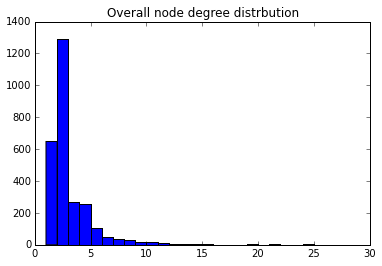

In [40]:
plt.hist(degree.values(), max(degree.values())-1)
plt.xlim(xmax=30)
plt.title('Overall node degree distrbution')

* While the highest degree is 80 (cut off), overall this is not super long-tailed
* Also really interesting that the highest peak is 2
* So most local users talk to 2 other local users
* And then it looks a bit step-wise (noise?)

### Incorporate  edge weights into the degree distribution

In [41]:
A=nx.adjacency_matrix(G)
strength=np.array(A.sum(axis=1)).reshape(-1) + np.array(A.sum(axis=0)).reshape(-1)

/home/mako0970/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


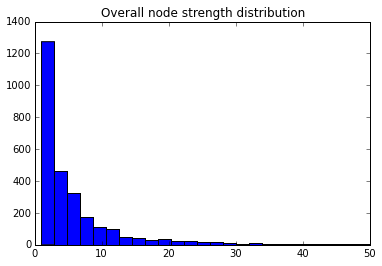

In [42]:
plt.hist(strength, 125)
plt.xlim(xmax=50)
plt.title('Overall node strength distribution')

**The order of degree sequence and the order of the nodes in the adjacency matrix (nodelist) are different!!!!!**

In [43]:
nodelist=G.nodes()

In [44]:
# REORDER the degree sequence to match the nodelist
from collections import OrderedDict
orderedDegree=OrderedDict((n, degree[n]) for n in nodelist)

/home/mako0970/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


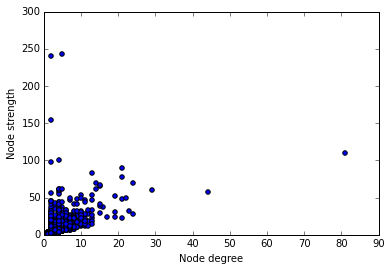

In [45]:
plt.scatter(orderedDegree.values(), strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node degree')
plt.ylabel('Node strength')

In [47]:
degree.keys()[degree.values().index(81)]

u'NYCMayorsOffice'

In [48]:
nodelist.index('NYCMayorsOffice')

1399

In [49]:
strength[1399]

110.0

In [50]:
degree.keys()[degree.values().index(44)]

u'patkiernan'

In [51]:
nodelist.index('patkiernan')

2638

In [52]:
strength[2638]

57.0

In [62]:
G['patkiernan']

{u'CGlush': {'weight': 1.0},
 u'EricCarvin': {'weight': 1.0},
 u'ItsMeSpector': {'weight': 1.0},
 u'KarenBlumberg': {'weight': 1.0},
 u'SteveScottWCBS': {'weight': 1.0},
 u'frankmorano': {'weight': 1.0},
 u'jfryer2000': {'weight': 1.0},
 u'jonathanmena': {'weight': 1.0},
 u'kendrad': {'weight': 1.0}}

**Takeways:**
* So the really frequent interactions happen to the low-degree users - few high-frequency conversation partners
* But then there is a diagonal trend - the bigger degree the bigger the strength
* So for the buld of users, their interactions are more or less evenly distributed across their contacts
* Say, 5 interactions per contact on average - adds up to a diagonal trend
* And most volume is concetrated at the origin - most people have few friends and don't talk to them too often
* And then there is NYCMayorsOffice - with 80 contacts and 108 conversations across them
* We know that 10 people responded to the cancelling marathon tweet
* People respond to it often! Not a single original tweet by it in our set
* The other extremish case is Pat Kiernan - the morning anchor for NY1
* He has 9 originals (or responses to others) and 47 replies to him - most are event-related

In [53]:
ratio=[x/y for x, y in zip(strength.tolist(), orderedDegree.values())]

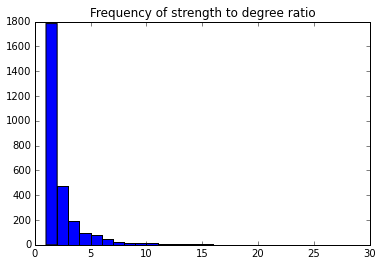

In [54]:
plt.hist(ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of strength to degree ratio')

In [55]:
np.median(ratio)

1.1909090909090909

In [56]:
ratio.index(120)

748

In [58]:
nodelist[748]

u'Megglezzz'

In [59]:
degree['Megglezzz']

2

In [60]:
G['Megglezzz']

{u'DDougyy': {'weight': 117.0}}

In [61]:
G['DDougyy']

{u'Megglezzz': {'weight': 123.0},
 u'MrXiphoid': {'weight': 1.0},
 u'Rach716': {'weight': 1.0}}

**Takeways:**
* Long tailed
* Vast majority of people have on average one interaction with each contact
* Sizable portion has two on average
* And then there are people in the tail - max is 120
* That's Megglezzz, who only talks to DDougyy (117 times) and he responds (123 times)
* They also have the longest conversation (43 steps) - teenagers at the time
* Can look at people **who have high weights** - commintment to their friend

### In- and Out-degree and Strength Distributions

#### In-degree

In [63]:
indeg=G.in_degree()

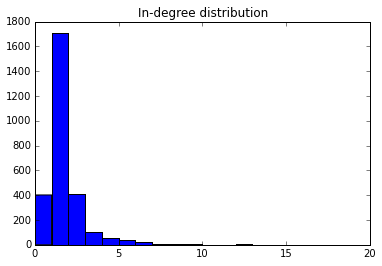

In [64]:
plt.hist(indeg.values(),max(indeg.values()))
plt.xlim(xmax=20)
plt.title('In-degree distribution')

In [65]:
in_strength=np.array(A.sum(axis=0)).reshape(-1)

In [66]:
A.sum(axis=0)

matrix([[ 1.,  1.,  1., ...,  1.,  8.,  2.]])

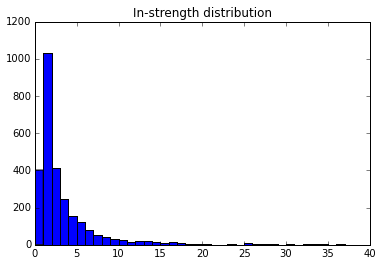

In [67]:
plt.hist(in_strength,max(in_strength))
plt.xlim(xmax=40)
plt.title('In-strength distribution')

In [68]:
# REORDER the in_degree sequence to match the nodelist
ordInDegree=OrderedDict((n, indeg[n]) for n in nodelist)

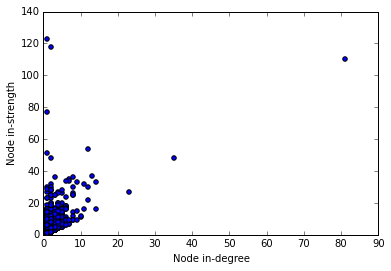

In [69]:
plt.scatter(ordInDegree.values(), in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node in-degree')
plt.ylabel('Node in-strength')

In [70]:
indeg.keys()[indeg.values().index(35)]

u'patkiernan'

In [71]:
in_ratio=[x/y if y!=0 else 1 for x, y in zip(in_strength.tolist(), ordInDegree.values())]

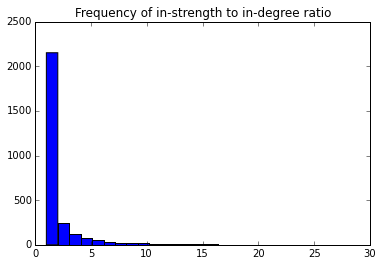

In [72]:
plt.hist(in_ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of in-strength to in-degree ratio')

In [73]:
np.median(in_ratio)

1.0

**Takways:**
* So most people are replied to by two friends
* And for in-strength(unlike overall), two is also the highest peak
* This means most users have to interactions, on average one per friend
* There is still a very clear diagonal effect in the in-strength to in-degree ratio
* This means that most users have about equal number of interactions and friends - so on avg one per friend
* And then there are people on the left, being frequently resoponded to by a few firends
* And the NYCMayorOffice, that received 120 replies from 80 different users
* And Pat Kiernan who got 40 smth responses from 35 users

#### Out-degree

In [74]:
outdeg=G.out_degree()

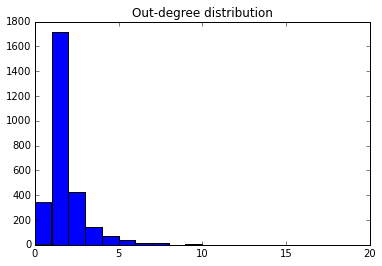

In [75]:
plt.hist(outdeg.values(),max(outdeg.values()))
plt.xlim(xmax=20)
plt.title('Out-degree distribution')

In [76]:
out_strength=np.array(A.sum(axis=1)).reshape(-1)

In [77]:
A.sum(axis=1)

matrix([[  0.],
        [  1.],
        [  0.],
        ..., 
        [  1.],
        [ 11.],
        [  2.]])

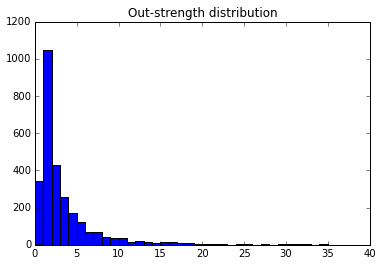

In [78]:
plt.hist(out_strength,max(out_strength))
plt.xlim(xmax=40)
plt.title('Out-strength distribution')

In [79]:
# REORDER the out_degree sequence to match the nodelist
ordOutDegree=OrderedDict((n, outdeg[n]) for n in nodelist)

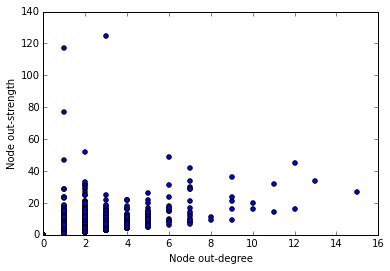

In [80]:
plt.scatter(ordOutDegree.values(), out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Node out-degree')
plt.ylabel('Node out-strength')

In [81]:
out_ratio=[x/y if y!=0 else 1 for x, y in zip(out_strength.tolist(), ordOutDegree.values())]

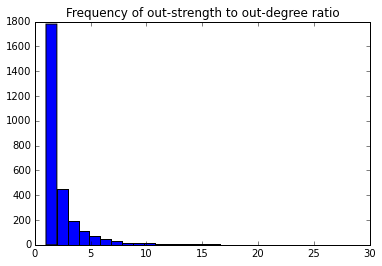

In [82]:
plt.hist(out_ratio, 119)
plt.xlim(xmax=30)
plt.title('Frequency of out-strength to out-degree ratio')

In [83]:
np.median(out_ratio)

1.0

**Takeways:**
* Our data set is biased towards the in-degree, because in includes replies, including the repliedWho
* But we don't alway have the outgoing tweets for those repliedWho users, since they might not been local
* Though we only include replies to other relevant-user tweets, so those outgoing tweets wouldn't be excluded cause they belong to an irrelevant user
* Should I supplement the user list from the global file?
* But all those users show up at the origin - the other pattern is unbiased (if we had the user, we'd have all their out replies)
* So we still have those couple users who reply a bunch to a handful of friends
* But the rest stay under 60 throghout the degree distribution
* This suggests that people have various degree of engagement with their friends, pretty much regardless to how many friends they reply to - but mostly users don't reply too often (more than 60 times)
* The slight diagonal trend (very low) suggests that besides those few users who answer a lot to few friends, most people produce a consistent number of replies to their friends, no matter how many 

#### Weight distribution

In [84]:
weights=nx.get_edge_attributes(G,'weight').values()

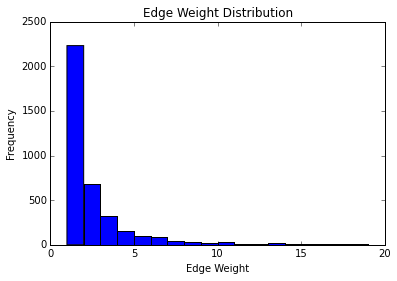

In [85]:
plt.hist(weights, max(weights)-1)
plt.xlim(xmax=20)
plt.ylim(ymin=0)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution')

* Long tailed
* Not surprising

### Reciprocity, transitivity, assortativity

In [86]:
nx.diameter(strong[0])

23

In [87]:
nx.diameter(nx.Graph(weak[0]))

25

In [88]:
reciprocity=sum([G.has_edge(e[1], e[0]) for e in G.edges_iter()])/float(G.number_of_edges())

In [89]:
reciprocity

0.710477698601214

**Takeaways:**
* High reciprocity 71%
* Makes sense considering it's a reply
* Still, there are many situations where people reply to celbrities and officials (NYCMayorOffice)
* This means that in this dataset most replies are part of actual conversation between equals (wrt status)
* We can see how the number of followers affects the reciprocity rate
* Also see how reciprocity changes over time slices

In [90]:
trans=nx.transitivity(G)

In [91]:
trans

0.09569762766385204

* Low transitivity
* If I reply to you, and you reply to Steve, I very rarely will reply to Steve also
* The conversational relationships do not spread
* We can also DO TRANSITIVE TRIPLE correction for directed graphs (RT paper code)

In [92]:
assort=nx.degree_assortativity_coefficient(G)

In [93]:
assort

0.050198634522847799

In [94]:
in_assort=nx.degree_assortativity_coefficient(G,x='in',y='in')

In [95]:
in_assort

-0.012889621894762769

In [96]:
out_assort=nx.degree_assortativity_coefficient(G,x='out',y='out')

In [97]:
out_assort

0.33535666625159111

In [98]:
oi_assort=nx.degree_assortativity_coefficient(G,x='out',y='in')

In [99]:
oi_assort

0.050198634522847799

In [100]:
io_assort=nx.degree_assortativity_coefficient(G,x='in',y='out')

In [101]:
io_assort

0.31195664478586571

**Takeways:**
* Overall assortativity is positive but very low
* So no strong relationship/clustering among people who reply and replied to a lot and others like them
* The directed assortativity versions are more illuminating
* Users who reply a lot are often connected to other users who reply a lot - we have these replying pairs
* But also users who are replied to a lot a connected to people who reply a lot

### Weighted assortativity

In [102]:
intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(G, 'weight').items()}

In [103]:
nx.set_edge_attributes(G,'weight', intWeights)

In [104]:
wassort=nx.degree_assortativity_coefficient(G, weight='weight')

In [105]:
wassort

0.17313937714380018

In [106]:
in_wassort=nx.degree_assortativity_coefficient(G,x='in',y='in', weight='weight')

In [107]:
in_wassort

0.13595619767937137

In [108]:
out_wassort=nx.degree_assortativity_coefficient(G,x='out',y='out', weight='weight')

In [109]:
out_wassort

0.44585896336052566

In [110]:
oi_wassort=nx.degree_assortativity_coefficient(G,x='out',y='in', weight='weight')

In [111]:
oi_wassort

0.17313937714380018

In [112]:
io_wassort=nx.degree_assortativity_coefficient(G,x='in',y='out', weight='weight')

In [113]:
io_wassort

0.45399537106229376

**Takeway:**
* The assortative trends are even stronger (a bit) when we account for edge weights
* So people with high out-strength reply to other people with high out-strength
* This means that people who either reply to many people or reply to their friends often tend to reply to others like that
* And people with high out-strength reply to people with high in-strength
* This means that people who are either replied to by many people or thier friends reply to them often tend to be replied to by other users who reply to either many or frequently

### Assortativity on being a conversationalist (in and out-ratio >1)

In [114]:
freqInTalk={key:True if r>1 else False for key, r in zip(ordInDegree.keys(),in_ratio)}

In [115]:
nx.set_node_attributes(G,'highInRatio',freqInTalk)

In [116]:
freqOutTalk={key:True if r>1 else False for key, r in zip(ordOutDegree.keys(),out_ratio)}

In [117]:
nx.set_node_attributes(G,'highOutRatio',freqOutTalk)

In [118]:
nx.attribute_assortativity_coefficient(G, 'highInRatio')

0.4333532638096198

In [119]:
nx.attribute_assortativity_coefficient(G, 'highOutRatio')

0.48401240502974785

In [120]:
bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(ordInDegree.keys(),in_ratio,out_ratio)}

In [121]:
nx.set_node_attributes(G,'highBothRatios',bothFreqTalk)

In [122]:
nx.attribute_assortativity_coefficient(G, 'highBothRatios')

0.6120396208097433

**Takeways:**
* 61% People who reply more than once on average to all their friends tend to talk to others like them
* People who are replied by their friends on average more than once tend to talk to other liken them
* And users who both reply and are replied by their friends on average more than once are VERY likely to talk to
others like then
* So frequent conversation is a two-way street
* CHECK with CONFIGURATION MODEL

### Centrality

In [211]:
sorted(nx.closeness_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'RickWebb', 0.20930232558139536),
 (u'steketee', 0.20382165605095542),
 (u'JamesDeanX', 0.2028169014084507),
 (u'arainert', 0.19766643788606725),
 (u'tonybgoode', 0.19341840161182),
 (u'af', 0.19290020093770932),
 (u'kristalberg', 0.1893491124260355),
 (u'harryh', 0.18872870249017037),
 (u'noneck', 0.18835840418574232),
 (u'caro', 0.18811234487263226),
 (u'dN0t', 0.18725617685305593),
 (u'Jmodio', 0.1867704280155642),
 (u'Shaila', 0.18664938431626701),
 (u'mbaratz', 0.18520900321543407),
 (u'BaconSeason', 0.18308963763509217),
 (u'cfohlin', 0.1819330385344283),
 (u'janatrantow', 0.18181818181818182),
 (u'kingsleyharris', 0.181360201511335),
 (u'helloericho', 0.180564263322884),
 (u'ckurdziel', 0.18045112781954886),
 (u'Stwo', 0.18045112781954886),
 (u'ModernUrbanLife', 0.179215930304916),
 (u'alexmiz', 0.17899316345556246),
 (u'tmilewski', 0.17899316345556246),
 (u'april_conyers', 0.17888198757763976),
 (u'smart', 0.17843866171003717),
 (u'joshspear', 0.1782178217821782),
 (u'JorgeO

In [213]:
sorted(nx.betweenness_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'caro', 0.25216263075867196),
 (u'Jmodio', 0.22640764774310457),
 (u'patkiernan', 0.20550280379999494),
 (u'af', 0.1975842915242082),
 (u'RickWebb', 0.16132318218694758),
 (u'Shaila', 0.1538011190995098),
 (u'arainert', 0.14822240537907985),
 (u'SimsJames', 0.1406246360024669),
 (u'kendrad', 0.13817036736062568),
 (u'katologic', 0.12372729881817215),
 (u'saschasegan', 0.11362203417952546),
 (u'binghott', 0.10769968302361595),
 (u'tonybgoode', 0.10767061994575859),
 (u'FrankRamblings', 0.10337525310485532),
 (u'Stwo', 0.10101298319604948),
 (u'geofffox', 0.09501047370167578),
 (u'gwhizkids', 0.09418865107018412),
 (u'JesseCFriedman', 0.09393271325570285),
 (u'jeffchatterton', 0.09215771589801229),
 (u'ikebrooker', 0.08401877123929968),
 (u'alexmiz', 0.08317673075026547),
 (u'cfohlin', 0.08280596466325843),
 (u'a0k', 0.08247302742291038),
 (u'mbaratz', 0.07502926044137714),
 (u'TimeOutNewYork', 0.07410214989338103),
 (u'DamianDazz', 0.06874487345751308),
 (u'gregmocker', 0.06738433142

In [214]:
sorted(nx.eigenvector_centrality(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'neiki2u', 0.49631236569599535),
 (u'caitiecoll', 0.4782051152716978),
 (u'chenyanqing', 0.4588408823046921),
 (u'ellactricitee', 0.3876712170186493),
 (u'LukeKingma', 0.3265848613982305),
 (u'ricenbeats', 0.16419258384218507),
 (u'MalbecBen', 0.10788438301544617),
 (u'gangsta_leen', 0.10306886626368689),
 (u'jessehutchison', 0.057141662642730705),
 (u'SeanValjean', 0.05013401418673682),
 (u'elisebartlett', 0.03809444176182047),
 (u'a0k', 0.019936247888095154),
 (u'krysXtyna', 0.019311376991934734),
 (u'jasonkeath', 0.015012966652573073),
 (u'Chefbriduff', 0.006301296819863708),
 (u'twatan', 0.003499513371161888),
 (u'BaconSeason', 0.0022903587024515515),
 (u'KimberlyAnneR', 0.0017824175300187196),
 (u'alexmiz', 0.001019551989262192),
 (u'lloyd_says', 0.0009401642399408083),
 (u'Thomas_Wendt', 0.0007725250711423127),
 (u'Jmodio', 0.0006564574741831005),
 (u'Stwo', 0.0006557754373114142),
 (u'harryh', 0.0006475468570091656),
 (u'JorgeO', 0.0004892686419462507),
 (u'DeidreDoom', 0.000

In [215]:
sorted(nx.pagerank(strong[0]).items(), key=lambda x:x[1], reverse=True)

[(u'patkiernan', 0.01917195806434515),
 (u'harryh', 0.01775843839273613),
 (u'Jmodio', 0.015030476371480977),
 (u'EricCarvin', 0.01484367979408208),
 (u'gregmocker', 0.013107410689166252),
 (u'RickWebb', 0.012051745297638578),
 (u'tonybgoode', 0.011757790481352316),
 (u'arainert', 0.011266349468459317),
 (u'geofffox', 0.010344257978153084),
 (u'caro', 0.009881962552500092),
 (u'JorgeO', 0.009790899343410308),
 (u'DeidreDoom', 0.009483730788564713),
 (u'buritica', 0.00913959744177275),
 (u'SteveScottWCBS', 0.009054867350110234),
 (u'rich1', 0.008069268323024197),
 (u'af', 0.008014734923249977),
 (u'JesseCFriedman', 0.007972017895314487),
 (u'chenyanqing', 0.00796985229201277),
 (u'sd', 0.007690067304820796),
 (u'frankmorano', 0.007465010668660272),
 (u'BobbyTBD', 0.007455066945301258),
 (u'ellactricitee', 0.007448023650548932),
 (u'cdessi', 0.007311909995176457),
 (u'sjkaliski', 0.007299678641896642),
 (u'MallorieRose', 0.007238462995460989),
 (u'neiki2u', 0.007170810157306489),
 (u'ero

## Analysis over the time slices

In [123]:
B=nx.read_weighted_edgelist('../data/replyUserNetBefore.csv',delimiter=',',create_using=nx.DiGraph())

In [124]:
D=nx.read_weighted_edgelist('../data/replyUserNetDuring.csv',delimiter=',',create_using=nx.DiGraph())

In [125]:
A=nx.read_weighted_edgelist('../data/replyUserNetAfter.csv',delimiter=',',create_using=nx.DiGraph())

In [126]:
L=nx.read_weighted_edgelist('../data/replyUserNetLafter.csv',delimiter=',',create_using=nx.DiGraph())

In [127]:
len(B)

786

In [128]:
B.number_of_edges()

789

In [129]:
len(D)

1768

In [130]:
D.number_of_edges()

2000

In [131]:
len(A)

1243

In [132]:
A.number_of_edges()

1310

In [133]:
len(L)

890

In [134]:
L.number_of_edges()

892

**Takeaway:**
* All the time slice networks are sparse
* Conversational patterns accrue over time
* And maybe 10 days is too short to see something?

### Components

#### Before

In [135]:
b_str_comps=nx.strongly_connected_component_subgraphs(B)

In [136]:
len(list(b_str_comps))

596

In [137]:
b_weak_comps=nx.weakly_connected_component_subgraphs(B)

In [138]:
len(list(b_weak_comps))

410

In [139]:
b_strong=sorted(nx.strongly_connected_component_subgraphs(B), key = len, reverse=True)

In [140]:
len(b_strong[0])

13

In [141]:
b_weak=sorted(nx.weakly_connected_component_subgraphs(B), key = len, reverse=True)

In [142]:
len(b_weak[0])

51

In [143]:
len(b_weak[0])/float(len(B))

0.0648854961832061

In [144]:
len(b_strong[0])/float(len(B))

0.01653944020356234

#### During

In [145]:
d_str_comps=nx.strongly_connected_component_subgraphs(D)

In [146]:
len(list(d_str_comps))

1292

In [147]:
d_weak_comps=nx.weakly_connected_component_subgraphs(D)

In [148]:
len(list(d_weak_comps))

662

In [149]:
d_strong=sorted(nx.strongly_connected_component_subgraphs(D), key = len, reverse=True)

In [150]:
len(d_strong[0])

71

In [151]:
d_weak=sorted(nx.weakly_connected_component_subgraphs(D), key = len, reverse=True)

In [152]:
len(d_weak[0])

527

In [153]:
len(d_weak[0])/float(len(D))

0.2980769230769231

In [154]:
len(d_strong[0])/float(len(D))

0.040158371040723985

#### After

In [155]:
a_str_comps=nx.strongly_connected_component_subgraphs(A)

In [156]:
len(list(a_str_comps))

930

In [157]:
a_weak_comps=nx.weakly_connected_component_subgraphs(A)

In [158]:
len(list(a_weak_comps))

570

In [159]:
a_strong=sorted(nx.strongly_connected_component_subgraphs(A), key = len, reverse=True)

In [160]:
len(a_strong[0])

13

In [161]:
a_weak=sorted(nx.weakly_connected_component_subgraphs(A), key = len, reverse=True)

In [162]:
len(a_weak[0])

142

In [163]:
len(a_weak[0])/float(len(A))

0.11423974255832663

In [164]:
len(a_strong[0])/float(len(A))

0.010458567980691875

#### Long After

In [165]:
l_str_comps=nx.strongly_connected_component_subgraphs(L)

In [166]:
len(list(l_str_comps))

665

In [167]:
l_weak_comps=nx.weakly_connected_component_subgraphs(L)

In [168]:
len(list(l_weak_comps))

438

In [169]:
l_strong=sorted(nx.strongly_connected_component_subgraphs(L), key = len, reverse=True)

In [170]:
len(l_strong[0])

10

In [171]:
l_weak=sorted(nx.weakly_connected_component_subgraphs(L), key = len, reverse=True)

In [172]:
len(l_weak[0])

26

In [173]:
len(l_weak[0])/float(len(L))

0.029213483146067417

In [174]:
len(l_strong[0])/float(len(L))

0.011235955056179775

**Takeway:**
* While all the networks are very sparse and don't have large strong or weakly connected components
* The During weakly connected component is QUITE A BIT larger (30%) than Before (7%)
* The After weakly connected component is also SLIGHTLY larger than before (11%)
* The Long After is the worst - the weakly connected comp is only 3% of the network
* So only in During large portion of the network (30%) is connected by people talking/replying to each other
* Other time slices have fragmented disconnected networks
* Do CHI-SQUARE!!!

### Degrees

In [175]:
b_degree=nx.degree(B)

In [176]:
np.median(b_degree.values())

2.0

In [177]:
d_degree=nx.degree(D)

In [178]:
np.median(d_degree.values())

2.0

In [179]:
a_degree=nx.degree(A)

In [180]:
np.median(a_degree.values())

2.0

In [181]:
la_degree=nx.degree(L)

In [182]:
np.median(la_degree.values())

2.0

* So all the 4 networks seem to have similar degree distribution
* 50% of the distribution is under degree of 2
* Meaning that half the users talk to up to two people

In [183]:
b_indeg=B.in_degree()

In [184]:
b_outdeg=B.out_degree()

In [185]:
np.median(b_indeg.values())

1.0

In [186]:
np.median(b_outdeg.values())

1.0

In [187]:
d_indeg=D.in_degree()

In [188]:
d_outdeg=D.out_degree()

In [189]:
np.median(d_indeg.values())

1.0

In [190]:
np.median(d_outdeg.values())

1.0

In [191]:
a_indeg=A.in_degree()

In [192]:
a_outdeg=A.out_degree()

In [193]:
np.median(a_indeg.values())

1.0

In [194]:
np.median(a_outdeg.values())

1.0

In [195]:
l_indeg=L.in_degree()

In [196]:
l_outdeg=L.out_degree()

In [197]:
np.median(l_indeg.values())

1.0

In [198]:
np.median(l_outdeg.values())

1.0

* So all the 4 networks seem to have similar in and out degree distribution
* 50% of both distribution is under degree of 1
* Meaning that half the users reply to and are replied by one other user

### Strength

In [199]:
bA=nx.adjacency_matrix(B)
b_strength=np.array(bA.sum(axis=1)).reshape(-1) + np.array(bA.sum(axis=0)).reshape(-1)

In [200]:
np.median(b_strength)

2.0

In [201]:
dA=nx.adjacency_matrix(D)
d_strength=np.array(dA.sum(axis=1)).reshape(-1) + np.array(dA.sum(axis=0)).reshape(-1)

In [202]:
np.median(d_strength)

2.0

In [203]:
aA=nx.adjacency_matrix(A)
a_strength=np.array(aA.sum(axis=1)).reshape(-1) + np.array(aA.sum(axis=0)).reshape(-1)

In [204]:
np.median(a_strength)

2.0

In [205]:
lA=nx.adjacency_matrix(L)
l_strength=np.array(lA.sum(axis=1)).reshape(-1) + np.array(lA.sum(axis=0)).reshape(-1)

In [206]:
np.median(l_strength)

2.0

### In Strength to Degree Ratios

#### Before

In [207]:
b_in_strength=np.array(bA.sum(axis=0)).reshape(-1)

In [208]:
# REORDER the in_degree sequence to match the nodelist
b_ordInDegree=OrderedDict((n, b_indeg[n]) for n in B.nodes())

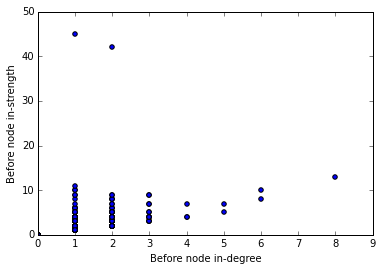

In [209]:
plt.scatter(b_ordInDegree.values(), b_in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Before node in-degree')
plt.ylabel('Before node in-strength')

In [210]:
b_in_ratio=[x/y if y!=0 else 1 for x, y in zip(b_in_strength.tolist(), b_ordInDegree.values())]

In [211]:
np.median(b_in_ratio)

1.0

#### During

In [212]:
d_in_strength=np.array(dA.sum(axis=0)).reshape(-1)

In [213]:
# REORDER the in_degree sequence to match the nodelist
d_ordInDegree=OrderedDict((n, d_indeg[n]) for n in D.nodes())

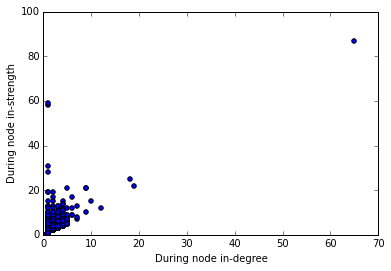

In [214]:
plt.scatter(d_ordInDegree.values(), d_in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('During node in-degree')
plt.ylabel('During node in-strength')

In [215]:
d_in_ratio=[x/y if y!=0 else 1 for x, y in zip(d_in_strength.tolist(), d_ordInDegree.values())]

In [216]:
np.median(d_in_ratio)

1.0

In [217]:
d_indeg.keys()[d_indeg.values().index(65)]

u'NYCMayorsOffice'

In [218]:
D.nodes().index('NYCMayorsOffice')

206

In [219]:
d_in_strength[206]

87.0

In [220]:
D['NYCMayorsOffice']

{}

#### After

In [221]:
a_in_strength=np.array(aA.sum(axis=0)).reshape(-1)

In [222]:
# REORDER the in_degree sequence to match the nodelist
a_ordInDegree=OrderedDict((n, a_indeg[n]) for n in A.nodes())

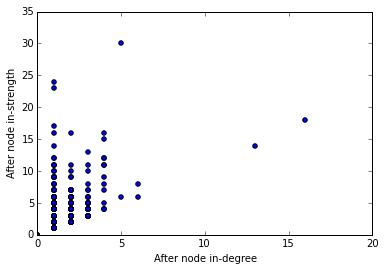

In [223]:
plt.scatter(a_ordInDegree.values(), a_in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('After node in-degree')
plt.ylabel('After node in-strength')

In [224]:
a_in_ratio=[x/y if y!=0 else 1 for x, y in zip(a_in_strength.tolist(), a_ordInDegree.values())]

In [225]:
np.median(a_in_ratio)

1.0

#### Long After

In [226]:
l_in_strength=np.array(lA.sum(axis=0)).reshape(-1)

In [227]:
# REORDER the in_degree sequence to match the nodelist
l_ordInDegree=OrderedDict((n, l_indeg[n]) for n in L.nodes())

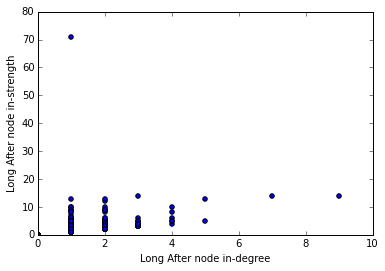

In [228]:
plt.scatter(l_ordInDegree.values(), l_in_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Long After node in-degree')
plt.ylabel('Long After node in-strength')

In [229]:
l_in_ratio=[x/y if y!=0 else 1 for x, y in zip(l_in_strength.tolist(), l_ordInDegree.values())]

In [230]:
np.median(l_in_ratio)

1.0

**Takeway:**
* Before there isn't a clear relationship between in-degree and in-strength - no matter degree, stength is mostly <10
* During there is a clear diagonal trend and most of the data is above the diagonal - avg weight to each friend
* After there is a also a clear diagonal trend (less steep than During) and most data is above it - with large spread
* Long after strength is almost horizonal and below 10
* This means that Before and Long After user receive more or less the same (low) number of replies regardless of how many friends are replying to them
* This means that the same number of interactions (being replied to) is spread over more and more friends
* In During and After periods, there is a clear diagonal - strength scales with degree
* This means that every friend sends some average (more or less constant) number of replies
* During there is also a couple of interesting outliers - especially those with few friends and many interacions
* Long after, above the diagonal is very dispersed - for the first 4 friends, various number of interactions are divided among them

### Out Strength to Degree Ratios

#### Before

In [231]:
b_out_strength=np.array(bA.sum(axis=1)).reshape(-1)

In [232]:
# REORDER the in_degree sequence to match the nodelist
b_ordOutDegree=OrderedDict((n, b_outdeg[n]) for n in B.nodes())

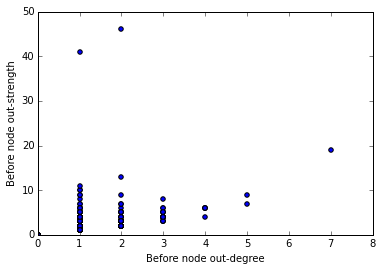

In [233]:
plt.scatter(b_ordOutDegree.values(), b_out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Before node out-degree')
plt.ylabel('Before node out-strength')

In [234]:
b_out_ratio=[x/y if y!=0 else 1 for x, y in zip(b_out_strength.tolist(), b_ordOutDegree.values())]

In [235]:
np.median(b_out_ratio)

1.0

#### During

In [236]:
d_out_strength=np.array(dA.sum(axis=1)).reshape(-1)

In [237]:
# REORDER the in_degree sequence to match the nodelist
d_ordOutDegree=OrderedDict((n, d_outdeg[n]) for n in D.nodes())

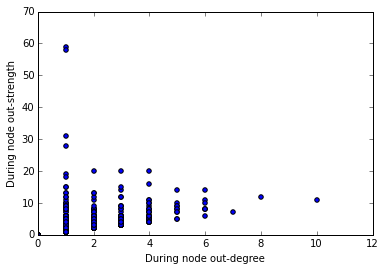

In [238]:
plt.scatter(d_ordOutDegree.values(), d_out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('During node out-degree')
plt.ylabel('During node out-strength')

In [239]:
d_out_ratio=[x/y if y!=0 else 1 for x, y in zip(d_out_strength.tolist(), d_ordOutDegree.values())]

In [240]:
np.median(d_out_ratio)

1.0

#### After

In [241]:
a_out_strength=np.array(aA.sum(axis=1)).reshape(-1)

In [242]:
# REORDER the in_degree sequence to match the nodelist
a_ordOutDegree=OrderedDict((n, a_outdeg[n]) for n in A.nodes())

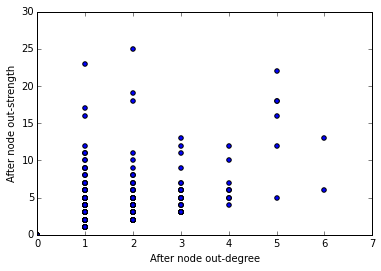

In [243]:
plt.scatter(a_ordOutDegree.values(), a_out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('After node out-degree')
plt.ylabel('After node out-strength')

In [244]:
a_out_ratio=[x/y if y!=0 else 1 for x, y in zip(a_out_strength.tolist(), a_ordOutDegree.values())]

In [245]:
np.median(a_out_ratio)

1.0

#### Long After

In [246]:
l_out_strength=np.array(lA.sum(axis=1)).reshape(-1)

In [247]:
# REORDER the in_degree sequence to match the nodelist
l_ordOutDegree=OrderedDict((n, l_outdeg[n]) for n in L.nodes())

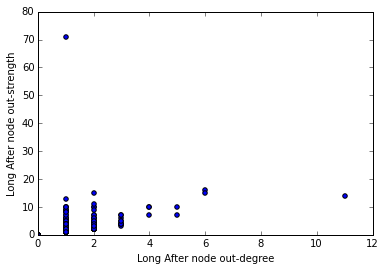

In [248]:
plt.scatter(l_ordOutDegree.values(), l_out_strength)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Long After node out-degree')
plt.ylabel('Long After node out-strength')

In [249]:
l_out_ratio=[x/y if y!=0 else 1 for x, y in zip(l_out_strength.tolist(), l_ordOutDegree.values())]

In [250]:
np.median(l_out_ratio)

1.0

**Takeways:**
* There is no clear diagonal trend in any of the time slices
* This means that the out-strength does not scale with out-degree
* This suggests that more or less the same amount of interaction (replying) is spread around various number of friends
* People have limited amount of replies in them?
* How does this compare to overall out-ratio (CHECK)?

### Reciprocity and Transitivity

In [251]:
sum([B.has_edge(e[1], e[0]) for e in B.edges_iter()])/float(B.number_of_edges())

0.7465145754119138

In [252]:
sum([D.has_edge(e[1], e[0]) for e in D.edges_iter()])/float(D.number_of_edges())

0.6415

In [253]:
sum([A.has_edge(e[1], e[0]) for e in A.edges_iter()])/float(A.number_of_edges())

0.7068702290076336

In [254]:
sum([L.has_edge(e[1], e[0]) for e in L.edges_iter()])/float(L.number_of_edges())

0.7286995515695067

**Takeaways:**
* Reciprocity is lowest During
* Replying to officials which doesn't get a response
* This is consistent with During having 65 users reply to NYCMayorsOffice 87 times
* NYCMayorsOffice of course didn't respond to any of them back - low reciprocity

In [255]:
nx.transitivity(B)

0.08641975308641975

In [256]:
nx.transitivity(D)

0.10542929292929293

In [257]:
nx.transitivity(A)

0.062111801242236024

In [258]:
nx.transitivity(L)

0.1412037037037037

* Low transitivity across the board
* If I reply to you, and you reply to Steve, I very rarely will reply to Steve also
* The conversational relationships do not spread
* Highest for During and Long After

### Degree Assortativity

In [259]:
nx.degree_assortativity_coefficient(B)

0.30282655446018164

In [260]:
nx.degree_assortativity_coefficient(D)

0.020449025423445833

In [261]:
nx.degree_assortativity_coefficient(A)

0.10049876003008404

In [262]:
nx.degree_assortativity_coefficient(L)

0.18833251138697352

**Takeway:**
* High degree assortativity BEFORE means that users who had a lot of friends talked to others with a lot of friends
* And similarly, users with a few conversation partners talked to others like them in that respect
* Degree assortativity drops drastically During, and starts to slowly recover in the later periods
* This means that during the event, people were less likely to talk to others with the similar number of conversation partners
* Communication patterns became less homogeneous

In [263]:
nx.degree_assortativity_coefficient(B,x='in',y='in')

0.23622336465204327

In [264]:
nx.degree_assortativity_coefficient(D,x='in',y='in')

-0.064815067351663383

In [265]:
nx.degree_assortativity_coefficient(A,x='in',y='in')

-0.015956510513852315

In [266]:
nx.degree_assortativity_coefficient(L,x='in',y='in')

0.18695290285877394

* This suggests that Before people who have many reply partners were more likely to recieve replies from others who have many reply partners
* But During this dynamic shifted, with users who have many reply partners more likely recieving replies from those who have few reply partners
* That shift of more inhomogeneous reply behavior continued After, though less strongly
* And by Long After it stabilized back into the assortative replying
* NYCMayorsOffice is one example of such dissasortative mixing During - it has high in-degree, but people who reply to it do not

In [267]:
nx.degree_assortativity_coefficient(B,x='in',y='out')

0.36512734338130948

In [268]:
nx.degree_assortativity_coefficient(D,x='in',y='out')

0.33049462788583339

In [269]:
nx.degree_assortativity_coefficient(A,x='in',y='out')

0.34298878342836592

In [379]:
nx.degree_assortativity_coefficient(L,x='in',y='out')

0.25525978670898403

* In-out assort is strong throughout
* Because it's somewhat complementary
* People who recieve replies from many 'friends' tend receive replies from people who reply to many friends
* Or perhaps more intuitive: users who get replied to by a few friends receive replies from others who reply to a few friends
* Lower in Long After - not sure why

In [270]:
nx.degree_assortativity_coefficient(B,x='out',y='out')

0.27517203598227069

In [271]:
nx.degree_assortativity_coefficient(D,x='out',y='out')

0.28726996826691803

In [272]:
nx.degree_assortativity_coefficient(A,x='out',y='out')

0.22005974470603265

In [273]:
nx.degree_assortativity_coefficient(L,x='out',y='out')

0.16294290514888285

* The out-out also strong throughout, except dropiing a bit in Long After
* People who sent replies to a lot of people reply to others who send replies to a lot of people
* How is this not dampened by NYCMayorsOffice During?

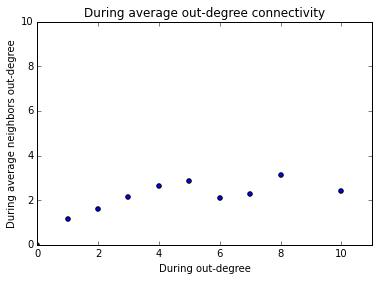

In [274]:
d_out_deg_con=nx.average_degree_connectivity(D, source='out',target='out')
plt.scatter(d_out_deg_con.keys(), d_out_deg_con.values())
plt.xlim(xmin=0,xmax=11)
plt.ylim(ymin=0,ymax=10)
plt.xlabel('During out-degree')
plt.ylabel('During average neighbors out-degree ')
plt.title('During average out-degree connectivity')

* The relationship is positive
* But it's not strong and the growth in avg neighbor out-degree goes up to about 4

In [275]:
nx.degree_assortativity_coefficient(B,x='out',y='in')

0.30282655446018164

In [276]:
nx.degree_assortativity_coefficient(D,x='out',y='in')

0.020449025423445833

In [277]:
nx.degree_assortativity_coefficient(A,x='out',y='in')

0.10049876003008404

In [278]:
nx.degree_assortativity_coefficient(L,x='out',y='in')

0.18833251138697352

**Assortativity Takeways:**
* Overall degree assortativity, in-in assortattivity, and out-in assortativity start resonably strong (0.3is) Before
* But then During they crash - go down in overall and out-in or even go slightly negative in in-in
* Out-in dropping suggests that During, users who replied to many reply partners were not very likely to receive a reply from others who receive replies from many conversation partners
* This again, can be exemplifief by NYCMayorsOffice - receives lots of replies, replied to by users who do not receive or send replies to many users (***BINGO!!!!***)
* Overall, this means that During celebrity or official accounts were getting a lot of replies from regular users
* To some degree, this persisted into After, but then by Long After the normla assortative patterns returned

### Strength assortativity

#### Overall

In [279]:
b_intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(B, 'weight').items()}

In [280]:
nx.set_edge_attributes(B,'weight', b_intWeights)

In [281]:
nx.degree_assortativity_coefficient(B, weight='weight')

0.55384637762918398

In [282]:
d_intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(D, 'weight').items()}

In [283]:
nx.set_edge_attributes(D,'weight', d_intWeights)

In [284]:
nx.degree_assortativity_coefficient(D, weight='weight')

0.10625435106934634

In [285]:
a_intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(A, 'weight').items()}

In [286]:
nx.set_edge_attributes(A,'weight', a_intWeights)

In [287]:
nx.degree_assortativity_coefficient(A, weight='weight')

0.41966542145402713

In [288]:
l_intWeights={key:int(round(val,0)) for key, val in nx.get_edge_attributes(L, 'weight').items()}

In [289]:
nx.set_edge_attributes(L,'weight', l_intWeights)

In [290]:
nx.degree_assortativity_coefficient(L, weight='weight')

0.67296678785412045

* Drops during
* Very high everywhere else
* During, people who talk to many others frequently are less likely to talk to others who talk to many others frequently
* Can't separate many friends and frequent conversations - that's why need ratio!!!

#### In-in

In [291]:
nx.degree_assortativity_coefficient(B,x='in',y='in', weight='weight')

0.54990493622603953

In [292]:
nx.degree_assortativity_coefficient(D,x='in',y='in', weight='weight')

0.037402778099458155

In [293]:
nx.degree_assortativity_coefficient(A,x='in',y='in', weight='weight')

0.33704577000324099

In [294]:
nx.degree_assortativity_coefficient(L,x='in',y='in', weight='weight')

0.66163078559809141

* The edge weigths make more apparent the trends we saw in unweighted  assort
* In-in and out-in are especially affected During

#### Out-out

In [295]:
nx.degree_assortativity_coefficient(B,x='out',y='out', weight='weight')

0.49176568822183109

In [296]:
nx.degree_assortativity_coefficient(D,x='out',y='out', weight='weight')

0.58936301171516714

In [297]:
nx.degree_assortativity_coefficient(A,x='out',y='out', weight='weight')

0.48970993117235118

In [298]:
nx.degree_assortativity_coefficient(L,x='out',y='out', weight='weight')

0.61463984913048786

* Out-out is robust throughout
* Actually goes up During
* Complementarity of the conversation - so teh frequent conversation is still happenning during, despite the celebrity/official phenomenon

#### Out-in

In [299]:
nx.degree_assortativity_coefficient(B,x='out',y='in', weight='weight')

0.55384637762918398

In [300]:
nx.degree_assortativity_coefficient(D,x='out',y='in', weight='weight')

0.10625435106934634

In [301]:
nx.degree_assortativity_coefficient(A,x='out',y='in', weight='weight')

0.41966542145402713

In [302]:
nx.degree_assortativity_coefficient(L,x='out',y='in', weight='weight')

0.67296678785412045

* Out-in also drops during
* The celebrity/offical phenomenon

#### In-out

In [303]:
nx.degree_assortativity_coefficient(B,x='in',y='out', weight='weight')

0.56781195668421824

In [304]:
nx.degree_assortativity_coefficient(D,x='in',y='out', weight='weight')

0.58875579487763796

In [305]:
nx.degree_assortativity_coefficient(A,x='in',y='out', weight='weight')

0.54732417163225155

In [306]:
nx.degree_assortativity_coefficient(L,x='in',y='out', weight='weight')

0.68248350926658474

* In-out is robust throughout

### Strong tie assort

#### Before

In [307]:
b_freqInTalk={key:True if r>1 else False for key, r in zip(b_ordInDegree.keys(),b_in_ratio)}

In [308]:
nx.set_node_attributes(B,'highInRatio',b_freqInTalk)

In [309]:
b_freqOutTalk={key:True if r>1 else False for key, r in zip(b_ordOutDegree.keys(),b_out_ratio)}

In [310]:
nx.set_node_attributes(B,'highOutRatio',b_freqOutTalk)

In [311]:
nx.attribute_assortativity_coefficient(B, 'highInRatio')

0.4919510624597551

In [312]:
nx.attribute_assortativity_coefficient(B, 'highOutRatio')

0.4903135072572995

In [313]:
b_bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(b_ordInDegree.keys(),b_in_ratio,b_out_ratio)}

In [314]:
nx.set_node_attributes(B,'highBothRatios',b_bothFreqTalk)

In [315]:
nx.attribute_assortativity_coefficient(B, 'highBothRatios')

0.7300025665155274

#### During

In [316]:
d_freqInTalk={key:True if r>1 else False for key, r in zip(d_ordInDegree.keys(),d_in_ratio)}

In [317]:
nx.set_node_attributes(D,'highInRatio',d_freqInTalk)

In [318]:
d_freqOutTalk={key:True if r>1 else False for key, r in zip(d_ordOutDegree.keys(),d_out_ratio)}

In [319]:
nx.set_node_attributes(D,'highOutRatio',d_freqOutTalk)

In [320]:
nx.attribute_assortativity_coefficient(D, 'highInRatio')

0.38609756341822477

In [321]:
nx.attribute_assortativity_coefficient(D, 'highOutRatio')

0.446654336314576

In [322]:
d_bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(d_ordInDegree.keys(),d_in_ratio,d_out_ratio)}

In [323]:
nx.set_node_attributes(D,'highBothRatios',d_bothFreqTalk)

In [324]:
nx.attribute_assortativity_coefficient(D, 'highBothRatios')

0.6356822571705618

* In-ratio assortativity drops During
* People who are replied to more than once by their friends are slightly less likely to talk to others who also receive more than one reply from their friends
* The celebrity/offical phenomenon
* But both ratio assort went up!!!
* People who both reply and are replied to frequently to their freinds were more likely to talk to each other

#### After

In [325]:
a_freqInTalk={key:True if r>1 else False for key, r in zip(a_ordInDegree.keys(),a_in_ratio)}

In [326]:
nx.set_node_attributes(A,'highInRatio',a_freqInTalk)

In [327]:
a_freqOutTalk={key:True if r>1 else False for key, r in zip(a_ordOutDegree.keys(),a_out_ratio)}

In [328]:
nx.set_node_attributes(A,'highOutRatio',a_freqOutTalk)

In [329]:
nx.attribute_assortativity_coefficient(A, 'highInRatio')

0.4629989882211887

In [330]:
nx.attribute_assortativity_coefficient(A, 'highOutRatio')

0.5209088814953609

In [331]:
a_bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(a_ordInDegree.keys(),a_in_ratio,a_out_ratio)}

In [332]:
nx.set_node_attributes(A,'highBothRatios',a_bothFreqTalk)

In [333]:
nx.attribute_assortativity_coefficient(A, 'highBothRatios')

0.7247504078303426

* In and out ratio assort are more or less the same After
* But both goes up even further
* The push for people who have strong ties to talk to each other persists and intensifies After

#### Long After

In [334]:
l_freqInTalk={key:True if r>1 else False for key, r in zip(l_ordInDegree.keys(),l_in_ratio)}

In [335]:
nx.set_node_attributes(L,'highInRatio',l_freqInTalk)

In [336]:
l_freqOutTalk={key:True if r>1 else False for key, r in zip(l_ordOutDegree.keys(),l_out_ratio)}

In [337]:
nx.set_node_attributes(L,'highOutRatio',l_freqOutTalk)

In [338]:
nx.attribute_assortativity_coefficient(L, 'highInRatio')

0.5503353533610817

In [339]:
nx.attribute_assortativity_coefficient(L, 'highOutRatio')

0.5363055140221974

In [340]:
l_bothFreqTalk={key:True if (i>1) & (o>1) else False for key,i,o in zip(l_ordInDegree.keys(),l_in_ratio,l_out_ratio)}

In [341]:
nx.set_node_attributes(L,'highBothRatios',l_bothFreqTalk)

In [342]:
nx.attribute_assortativity_coefficient(L, 'highBothRatios')

0.7286058561272444

** Strong Ties Assort Takeaways:**
* Before in, out, and both are about 50% - good number of people talk to others like them
* During the in drops (celebrity/official phenomenon), but both goes up - regular strong tie people talk to each other more
* After the both goes up even further (the rest about 50%) - need for coversations persists, strengthens
* And Long After, both is still up (less than After) - still need to talk
* Bring in the resilience of communities and ties

In [343]:
strongTieUsers=[key for key,val in bothFreqTalk.items() if val==True]

In [344]:
np.savetxt('../data/strongTieUsers.txt', strongTieUsers, fmt='%s', delimiter=',')